# Etivity 3: Clustering and Manifold Learning (Carla Warde - 17204542)
After my <b>Data Preparation</b> I am now ready to perform <b>Clustering and Manifold Learning</b> on the dataset.

This will be accomplished in the following steps:
<ol>
    <li>Import data and relevant modules</li>
    <li>Rescale data</li>
    <li>Scatterplot Function Visualisation</li>
    <li>K-Means Clustering and Analysis</li>
    <li>Apply an Alternative Clustering Technique and Analysis</li>
</ol>

## 1. Import Modules and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # for calculating K in K-Means

In [2]:
df = pd.read_csv("./loans_train_prepared.csv")
data = np.array(df.values, dtype=float)
data_copy = data
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (614, 16)


## 2. Rescale Data
Due to the data being rescaled in the previous etivity, it is not necessary to rescale it in this notebook.

## 3. Scatterplot Function Visualisation
The function `clustering_scatterplot` can be used to create a 2D scatter plot of the clustered dataset.

In [3]:
colors = np.array(['orange', 'blue', 'lime', 'yellow', 'khaki', 'pink', 'green', 'purple', 'grey', 'black', 'cyan', 
                   'magenta','brown', 'coral', 'teal'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot

def clustering_scatterplot(points, labels, centers, title):
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)
    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

## 4. K-Means Clustering

### 4.1 Testing Initial K-Value
Before trying to calculate the optimal $k$ value, let's choose a initial k value and visualise the clusters to gain a better understanding of the dataset first. I'm going to choose 3 as my $k$ value, in line with the example datset. I considered going with a higher value to match the number of attributes in the dataset (16), but for an initial value I plan on keeping things simple so it's easy to analyse.

In [4]:
k = 3
# run k-means
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)

In [5]:
# Append the cluster centers to the dataset
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]
# Project both the data and the k-Means cluster centers to 2D
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)

Now we're ready to plot the MDS visualisation of the dataset.

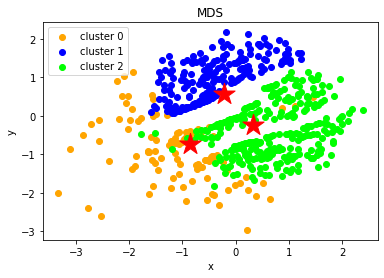

In [6]:
# plot MDS
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

In [7]:
# Project both the data and the k-Means cluster centers to 2D
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)

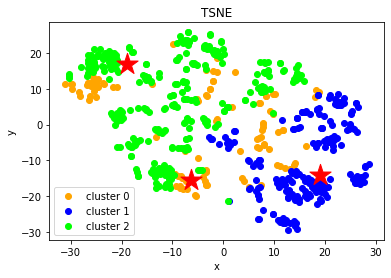

In [8]:
# plot t-SNE visualisation of the dataset
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

### 4.2 Initial Cluster Analysis

From the above plots, it can be concluded that the clusters are not very distinct. There's a lot of spread, and thus it can be concluded there's a lot of overlap between the clusters.

As such, there may be a different value of $k$ that is more suitable for this dataset.

### 4.3 Calculating $K$
To utilise K-Means Clustering on our dataset in the best way possible, we must determine the best value for $k$. There are a variety of methods to do this, one being the <b>elbow criterion</b>. 

This method involves calculating the sum of squared errors (SSE) for a range of potential $k$ and plotting it. The goal is to choose a small value of $k$ that still has a low SSE, and the rule of thumb is that the 'elbow' usually represents where we start to have diminishing returns by increasing $k$.

So then by checking where the graph looks like the elbow joint of an arm, or a bend in otherwords, we can determine that's the best value for $k$.

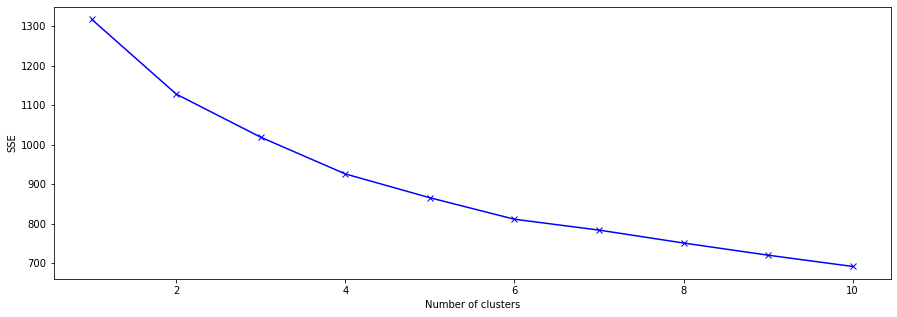

In [9]:
# reset data
data = data_copy
X = pd.DataFrame(data)

sse = {}
# calculate sse for i in range 1 to 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300).fit(X)
    X["clusters"] = kmeans.labels_
    sse[i] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
# plot sse values
plt.figure(figsize=(15, 5))
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

The above graph does not have an overly distinct 'elbow', thus I will also use the <b>Silhouette Coefficient</b> method to obtain further information on the optimal $k$. A higher Silhouette Coefficient indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

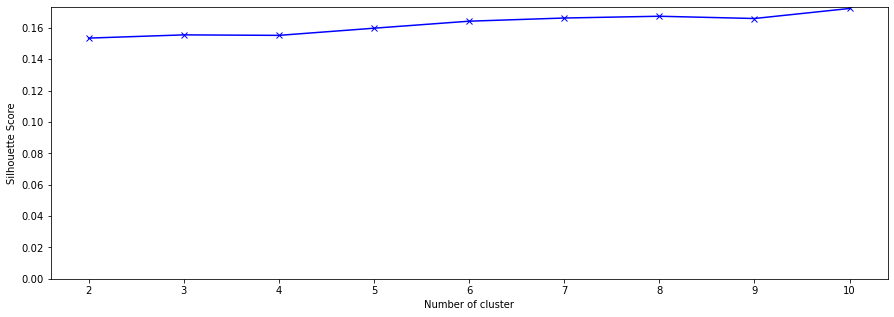

In [10]:
sc = {}
X = pd.DataFrame(data)
# calculate silhouette  coefficient for range 2 to 10
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i).fit(X)
    label = kmeans.labels_
    sc[i] = silhouette_score(X, label, metric='euclidean')
    
# plot graph of sc in chosen range
plt.figure(figsize=(15, 5))   
plt.plot(list(sc.keys()), list(sc.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.ylim(ymin=0)
plt.show()

Based on the previous two plots, it can be argued that 6 is indeed the optimal value for $k$. This is due to the fact that there's a very minor decrease in SSE after 6 and a relatively minor change in the Silhouette score. (10 does have the highest Silhouette Score,  but this is only an increase of approx 0.01 so it's negligible.) Unfortunately, these low scores just indicates that the clusters in the dataset are just not very distinct regardless of the value of $k$. Despite this, we can still analyse the clusters.

### 4.4 New K-Means Clustering
Using our calculated $k$ of 6, let's use k-means clustering once again and plot the results to MDS and TSNE scatterplots.

In [11]:
k = 6
# run k-means
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)
# Append the cluster centers to the dataset
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]

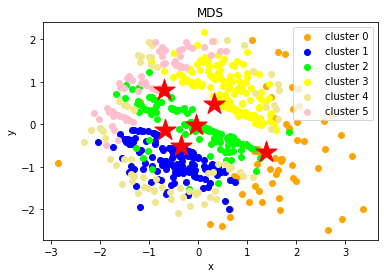

In [12]:
# Project both the data and the k-Means cluster centers to 2D
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)
# plot MDS
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

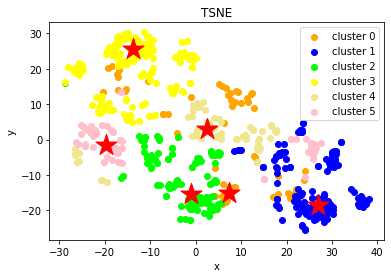

In [13]:
# Project both the data and the k-Means cluster centers to 2D
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
# plot t-SNE visualisation of the dataset
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

### 4.5 K-Means Cluster Analysis and Conclusion
Already we can see that these clusters are more distinct than our previous graphs when $k$ was 3. To gain a better understanding of the differences between the clusters, we can add `cluster` as a column to the dataframe. Then by grouping by cluster, we can calculate the mean value for each attribute in the different clusters.

In [14]:
# add cluster column to data_copy
data_copy = df
data_copy['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=data_copy.index)
#calculate means
data_copy.groupby('cluster').mean()

,Dependents,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Gender_nan,Married_Yes,Married_nan,Self_Employed_Yes,Self_Employed_nan,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncome
cluster,,,,,,,,,,,,,,,,
0,0.385057,1.817979,1.596403,0.702586,0.862069,0.775862,0.086207,0.741379,0.000000,0.362069,0.051724,0.034483,0.344828,0.310345,0.655172,1.773572
1,0.267640,0.825008,1.009968,0.690328,0.992701,0.978102,0.000000,0.737226,0.007299,0.094891,0.065693,0.189781,0.000000,1.000000,0.759124,0.783891
2,0.229885,0.826145,1.053969,0.716379,0.982759,0.948276,0.017241,0.706897,0.000000,0.120690,0.077586,0.310345,0.000000,0.000000,0.750000,0.808748
3,0.254658,0.822841,1.055924,0.720497,0.987578,0.888199,0.006211,0.770186,0.006211,0.118012,0.031056,0.217391,1.000000,0.000000,0.888199,0.794585
4,0.253333,0.798718,1.011672,0.723333,0.000000,0.760000,0.040000,0.640000,0.000000,0.106667,0.013333,0.333333,0.320000,0.360000,0.000000,0.727020
5,0.099502,0.837349,0.920955,0.736194,0.985075,0.000000,0.029851,0.000000,0.014925,0.104478,0.074627,0.149254,0.417910,0.298507,0.746269,0.644170


The following can be observed about the table:
<ul>
    <li>Cluster 5 has a much lower `Dependents` values than the rest of the clusters. This cluster also has the lowest mean LoanAmount - the only one which drops below 1.0.</li>
    <li>Cluster 0 has a much larger mean ApplicantIncome than the rest of the clusters who share very similar means. It also has the highest mean LoanAmount.</li>
    <li>Cluster 4 has the lowest Credit_History value at 0; the next lowest is 0.85</li>
    <li>Cluster 5 has a Gender_Male values of 0.0 which is immensely lower than all other clusters. It also has a really low Married_Yes value in comparison to the other clusters.</li>
    <li>Cluster 0 has by far the highest Self_Employed_Yes value. This is interesting to to note considering this cluster also has the highest ApplicantIncome.</li>
    <li>Clusters 4 ans 2 have the highest mean Education_NotGraduate by a relatively large margin. In comparison, Cluster 0 has by far the lowest mean.</li>
    <li>Cluster 1 applicants all reside in Urban properties whereas in Cluster 3 they all reside in Semiurban properties. Cluster 2 has 0 in both properties categories.</li>
    <li>Cluster 4 has a Loan_Status_Y of 0, in contrast Cluster 3 has the highest rate at 0.88.</li> 
</ul>

Thus I conclude the following about the clusters:
<ul>
    <li>Cluster 0 are weathly, college-graduate entrepreneurs.</li>
    <li>Cluster 1 applicants all have urban properties.</li>
    <li>Cluster 2 have no properties, but considering they have the second highest loan yes rate, it could be suggested that these loans may be used to buy properties in the future.</li>
    <li>Cluster 3 has has solely Semiurban properties. These applicants also have the highest yes loan status. Strangely, the very high property attribute the only attribute I can see that affects the Loan_Status_Y in comparison to other clusters.</li>
    <li>Cluster 4 has the highest amount of non-university graduates with a low loan yes rate which is possibly due to their poor credit history.</li>
    <li>Cluster 5 are mostly single, childless applicants.</li>
</ul>

<i>These results may change if the code is run again, or may have different cluster numbers.</i>

## 5. Apply an alternative clustering technique
Considering that our data does not have a distinct elbow and has a generally low Silhouette Coefficiency value, I believe that the Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise, or <b>DBSCAN</b> is a potentially good clustering technique to use on our dataset.

The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples).

Unlike K-Means, DBSCAN does not assume clusters are convex shaped; clusters can come in any shape. It also has a parameter called `eps` which dictates the tolerance towards 'noise' or in other words, outliers. This enables clusters to form even if there is a lot of noise in the data.

Therefore DBSCAN has a good chance of working well with the dataset since it can account for outliers unlike K-Means.

### 5.1 Determine `eps` and `min_samples` parameters
There are two main parameters in DBSCAN:
<ul>
    <li><b>eps:</b> The maximum distance between two samples for them to be considered neighbours.</li>
    <li><b>min_samples:</b> The minimum number of samples in a neighbourhood for it to be considered a core point.</li>
</ul>

To begin let's have an `eps` of 0.3 and a `min_samples of 10`, in line the the DBSCAN demo found <a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py" target="_blank">here</a>.

In [64]:
# reset data
df = pd.read_csv("./loans_train_prepared.csv")
data = np.array(df.values, dtype=float)

db = cluster.DBSCAN(eps=0.3, min_samples = 10).fit(data)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)

Estimated number of clusters: 3
Estimated number of noise points: 566


These parameters give us an estimate 3 clusters and 566 noise points. This is quite a lot of noise, so let's try to refine the parameter values to see if the noise is reduced. If `eps` is too low, it doesn't create very distinct clusters, and if it's too high all the data will just converge into one cluster. As for `min_samples`, we need to make sure it's not too big or it'll be overly tolerant of noise.

In [65]:
# eps = 0.6, min_samples = 10
db = cluster.DBSCAN(eps=0.6, min_samples = 10).fit(data)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)

Estimated number of clusters: 9
Estimated number of noise points: 391


In [66]:
# eps = 0.6, min_samples = 20
db = cluster.DBSCAN(eps=0.6, min_samples = 20).fit(data)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)

Estimated number of clusters: 3
Estimated number of noise points: 488


In [67]:
# eps = 0.6, min_samples = 5
db = cluster.DBSCAN(eps=0.6, min_samples = 5).fit(data)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)

Estimated number of clusters: 22
Estimated number of noise points: 286


After testing some different values for `eps` and `min_samples`, I believe that eps = 0.6 and min_samples = 10 produces the best result. While min_samples = 5 produces the lowest number of noise points, its cluster number of 22 is far too high considering the dataset only has 16 attributes. The values I selected are a good middleground between number of clusters and number of noise points.

### 5.2 DBSCAN Clustering and Visualisation

In [75]:
# reset data
df = pd.read_csv("./loans_train_prepared.csv")
data = np.array(df.values, dtype=float)

db = cluster.DBSCAN(eps=0.6, min_samples = 10).fit(data)
labels = db.labels_

data_dbscan = np.r_[data]

Before we can plot our DBSCAN we need to make some adjustments to our earlier `clustering_scatterplot` function. Unlike K-Means, DBSCAN clusters start from -1 rather than 0. Futhermore, we no longer need the `centers` parameter as we're not marking the centers of the clusters since DBSCAN recursively defines centers so it would make the graph rather messy.

In [76]:
def clustering_scatterplot(points, labels, title):
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        # i-1 since DBSCAN starts at -1
        h = plt.scatter(points[labels==i-1,0],
                        points[labels==i-1,1], 
                        c=colors[i],
                        label = 'cluster '+str(i))

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

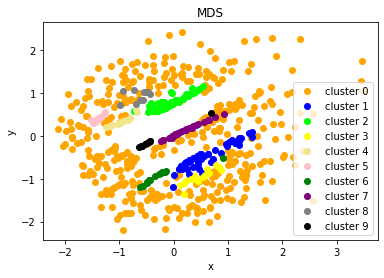

In [77]:
# Project both the data to 2D
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_dbscan)
# plot MDS
clustering_scatterplotDBSCAN(points=XYcoordinates, 
                       labels=db.labels_,
                       title='MDS')

In DBSCAN clustering, data that is considered noisy is assigned a value of -1. This is why the orange cluster is so large and dispersed in comparison to the other data; it contains all the noisy data that DBSCAN deemed unncessary.

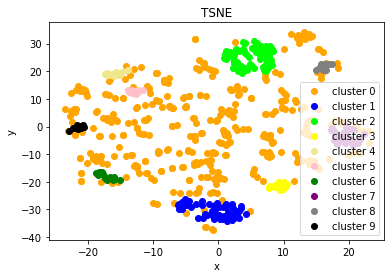

In [79]:
# Project both the data and the k-Means cluster centers to 2D
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_dbscan)
# plot t-SNE visualisation of the dataset
clustering_scatterplotDBSCAN(points=XYcoordinates, 
                       labels=db.labels_,
                       title='TSNE')

We can see that the clusters, bar Cluster 0 which consists of noise, are not overly dispersed. This indicates that the clusters are distinct from their neighbours so we should be able to derive some interesting conclusions. However it must be noted that Cluster 0 is far larger than the other clusters.

### 5.3 DBSCAN Cluster Analysis and Conclusion
Like with K-Means, we can analyse the mean values for the DBSCAN clusters.

In [94]:
# add cluster column to data_copy
data_copy = df
data_copy['cluster'] = pd.Series(db.labels_, index=data_copy.index)
#calculate means
data_copy.groupby('cluster').mean()

,Dependents,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Gender_nan,Married_Yes,Married_nan,Self_Employed_Yes,Self_Employed_nan,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncome
cluster,,,,,,,,,,,,,,,,
-1,0.260870,0.962508,1.091401,0.710166,0.772379,0.705882,0.033248,0.570332,0.007673,0.209719,0.081841,0.278772,0.345269,0.299233,0.508951,0.899409
0,0.327273,0.890291,1.061537,0.692273,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.840313
1,0.282051,0.870279,1.126631,0.734615,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.841774
2,0.400000,0.752697,1.003116,0.666667,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.756432
3,0.000000,0.715605,0.903124,0.740385,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.638161
4,0.033333,0.803299,0.875678,0.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.555697
5,0.022222,0.843924,0.889934,0.750000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.655862
6,0.122222,0.807831,1.121749,0.720833,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.892710
7,0.366667,0.669735,0.888561,0.700000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.655573


The following can be noted about the table:
<ul>
    <li>Cluster -1 is the only Cluster with a mean Credit_History and Loan_Status_Y below 1.</li>
    <li>Cluster 3 and 9 have a mean Dependents of 0.</li>
    <li>Cluster 4 is the only cluster with a Gender_Male mean of 0, the rest, bar Cluster -1, have a mean of 1.</li>
    <li>Cluster -1 is the only cluster with Self_Employed_Yes above 0.</li>
    <li>Cluster 2 and 7 have Education_Non_Graduate mean of 1, the rest are 0, bar Cluster -1.</li>
    <li>Clusters 1, 3, 4 and 7 have Semiurban properties, clusters 0, 2 and 5 have Urban properties, while clusters 6 and 8 have neither.</li>
</ul>

Based on observations made on the means table and the MDS and TSNE plots, I have come to the following conclusions:
<ol>
    <li>There's a lot of noise in the DBSCAN to the extent that Cluster -1 is huge in comparison to the other clusters.</li>
    <li>This has caused the other clusters to hugely skew to boundary values.</li>
    <li>Cluster 0 has some of the married wealthier male applicants who are college graduates with dependents, who have urban properties.</li>
    <li>Cluster 1 has some of the married higher male applicants who are college graduates with dependents, who have semi-urban properties.</li>
    <li>Cluster 2 has some of the married lower income male applicants who aren't college graduates with dependents, who have urban properties.</li>
    <li>Cluster 3 has some of the single lower income male applicants who are college graduates with no dependents, who have semi-urban properties.</li>
    <li>Cluster 4 has some of the single average income female applicants who are college graduates with very few dependents, have semi-urban properties.</li>
    <li>Cluster 5 has some of the single average income male applicants who are college graduates with very few dependents, who have urban properties.</li>
    <li>Cluster 6 has some of the married average income male applicants who are college graduates with some dependents, who have neither urban or semi-urban properties.</li>
    <li>Cluster 7 has some of the married lower income male applicants who aren't college graduates with dependents, who have semi-urban properties.</li>
    <li>Cluster 8 has some of the single higher income male applicants who are college graduates with no dependents, who have neither urban or semi-urban properties.</li>
</ol>

<i>These conclusions are relevant for the current execution of the notebook. If it is run again, the results may change or clusters may be assigned different numbers.</i>